In [1]:
from libemg.feature_extractor import FeatureExtractor
import numpy as np
import itertools
import re
import os
from typing import Dict, List
from itertools import combinations

import pandas as pd

from matplotlib import pyplot as plt

from emgstatedetect.providers.biopatrec.biopatrec_classes import BioPatRecRecordingDataset
from emgstatedetect.providers.biopatrec.biopatrec_libemg_adapters.adapter_10mov4chFU_AFEs import Device, ValuesState, AnalogFrontEnd_UntargetedForearm
from emgstatedetect.visualizations.plots import plot_multisubject_multiclass_multichannel, plot_raw_segmented_clean_one_subject_one_class
from emgstatedetect.state_detection.class_asignment import map_window_labels_to_samples_by_voting, assign_class_to_labels
from emgstatedetect.data_stages.stages import *

/usr/local/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Bluepy not installed...


In [2]:
dataset = BioPatRecRecordingDataset('10mov4chFU_AFEs', '10mov4chFU_AFEs', persist_source=True)

TIADS1299_dataset = AnalogFrontEnd_UntargetedForearm(dataset_info=dataset.info, device=Device.ADS)

2025-06-07 15:26:36 [INFO] biopatrec_classes.__init__: Initializing BioPatRecRecordingDataset for: 10mov4chFU_AFEs
2025-06-07 15:26:36 [INFO] biopatrec_classes.__init__: Local folder '10mov4chFU_AFEs' exists and contains mat files. Loading existing .mat files.


Local folder path: /workspaces/EMGStateDetect/10mov4chFU_AFEs


In [3]:
# Load the raw stage data
TIADS1299_dataset.load_data(RawStage)

80 data files fetched out of 80 files.


In [4]:
TIADS1299_dataset.get_frequency_filtered_data()
TIADS1299_dataset.persist_data(FrequencyFilteredStage)

In [5]:
TIADS1299_dataset.clean_data(AllKmeansNoRestStage)
TIADS1299_dataset.load_data(AllKmeansNoRestStage)
TIADS1299_dataset.persist_data(AllKmeansNoRestStage)

80 data files fetched out of 80 files.


In [6]:
TIADS1299_dataset.clean_data(TrainKmeansNoRestStage)
TIADS1299_dataset.load_data(TrainKmeansNoRestStage)
TIADS1299_dataset.persist_data(TrainKmeansNoRestStage)

80 data files fetched out of 80 files.


In [7]:
TIADS1299_dataset.clean_data(AllPct70NoRestStage)
TIADS1299_dataset.load_data(AllPct70NoRestStage)
TIADS1299_dataset.persist_data(AllPct70NoRestStage)

80 data files fetched out of 80 files.


In [8]:
TIADS1299_dataset.clean_data(TrainPct70NoRestStage)
TIADS1299_dataset.load_data(TrainPct70NoRestStage)
TIADS1299_dataset.persist_data(TrainPct70NoRestStage)

80 data files fetched out of 80 files.


In [9]:
TIADS1299_dataset.load_data(GoldenDataStage)

80 data files fetched out of 81 files.


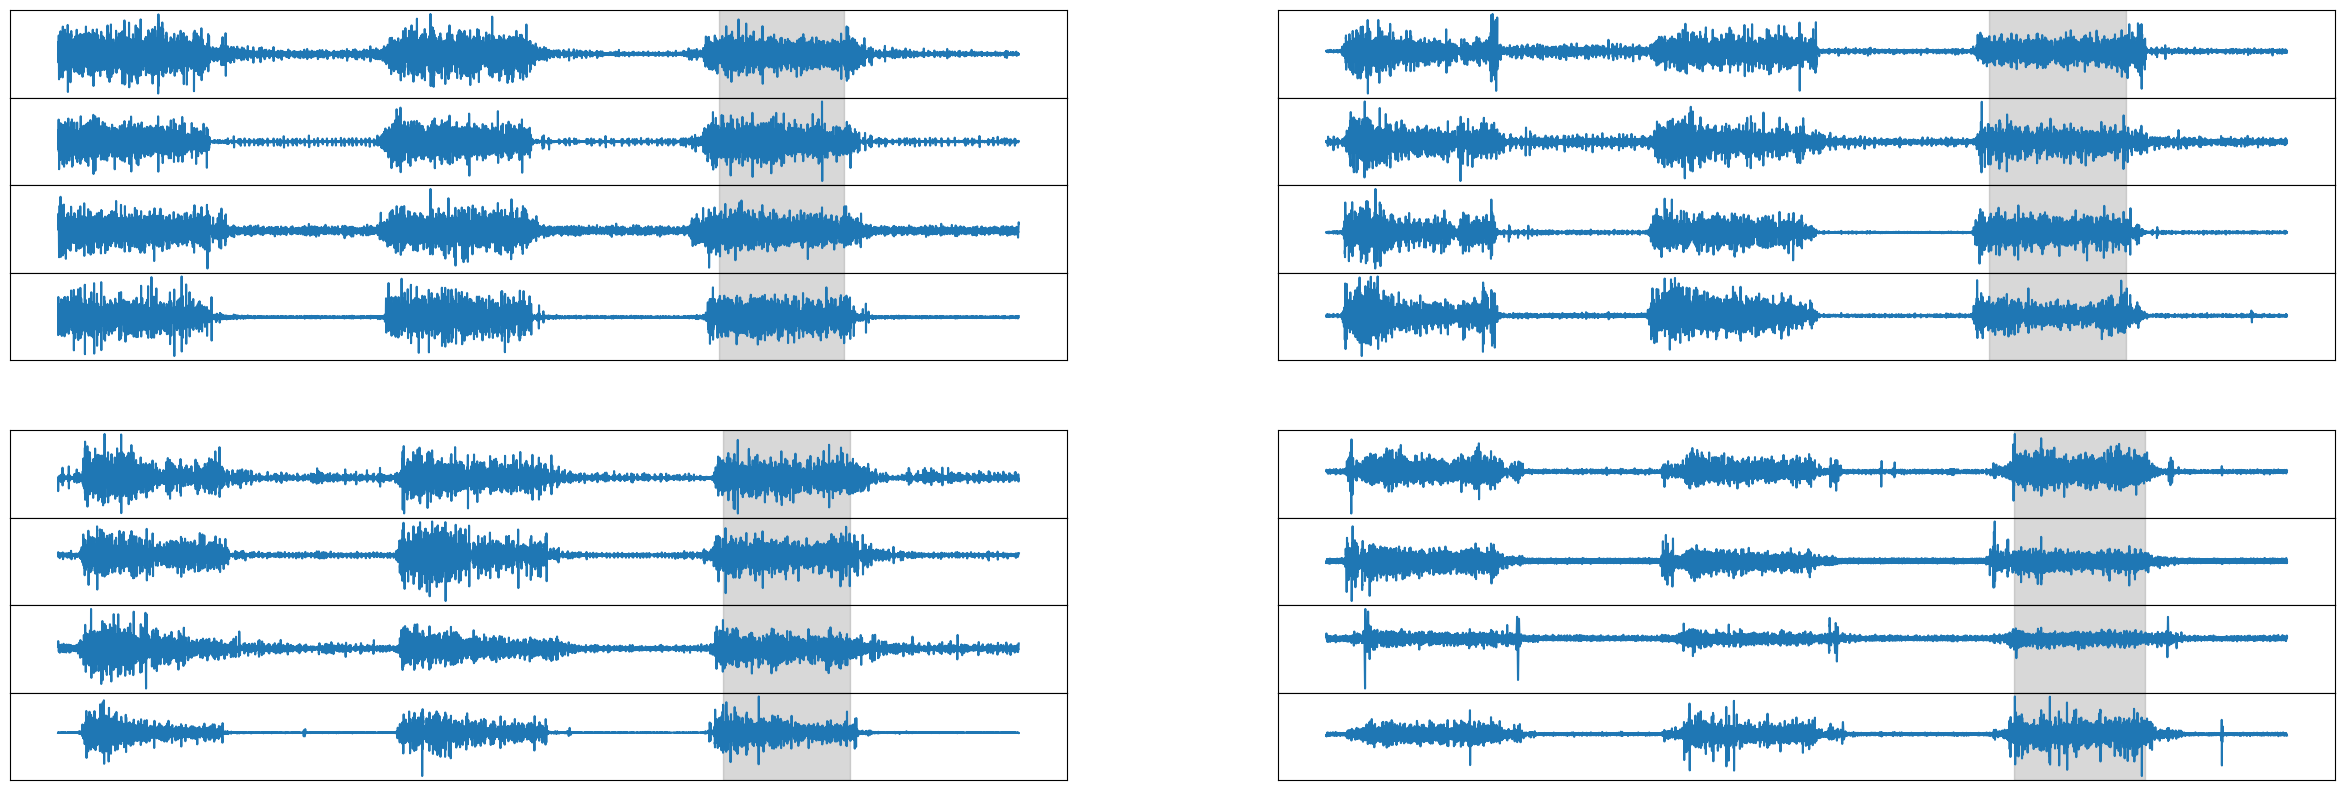

In [42]:
import itertools

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np



def plot_multisubject_multiclass_multichannel(signal: np.ndarray, fig_width: int = 30, fig_height: int = 10, limits=None) -> Figure:
    """
    signal: shape (subjects, classes, channels, samples)
    """
    fig = plt.figure(figsize=(fig_width, fig_height))
    subject_dim, classes_dim, signal_dim, num_samples = signal.shape
    outer_gs = fig.add_gridspec(subject_dim, classes_dim, hspace=0.2)
    j = -1
    for idx in list(itertools.product(list(range(subject_dim)), list(range(classes_dim)))):
        raw0_gs = outer_gs[idx[0], idx[1]].subgridspec(signal_dim, 1, hspace=0)
        j += 1
        for i in range(signal_dim):
            ax = fig.add_subplot(raw0_gs[i, 0])
            ax.axvspan(limits[j][0], limits[j][1], color='gray', alpha=0.3)
            ax.plot(signal[idx[0], idx[1], i])
            ax.set_yticks([])
            ax.set_xticks([])

    return fig

df = pd.read_csv('/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/splits.csv')

a0 = df[(df['subject']==0)&(df['class']==0)].to_dict(orient='records')[0]
a1 = df[(df['subject']==1)&(df['class']==1)].to_dict(orient='records')[0]
a2 = df[(df['subject']==2)&(df['class']==4)].to_dict(orient='records')[0]
a3 = df[(df['subject']==5)&(df['class']==5)].to_dict(orient='records')[0]

limits = [
    [a0['start'], a0['end']],
    [a1['start'], a1['end']],
    [a2['start'], a2['end']],
    [a3['start'], a3['end']]
]


data = np.array(
    [
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [0]).isolate_data('classes', [0]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [1]).isolate_data('classes', [1]).data[0].transpose().reshape(4, 36000)
    ],
    [
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [2]).isolate_data('classes', [4]).data[0].transpose().reshape(4, 36000),
        TIADS1299_dataset.freq_filtered_stage.odh.isolate_data('subjects', [5]).isolate_data('classes', [5]).data[0].transpose().reshape(4, 36000)
    ]
    ]
)

plot_multisubject_multiclass_multichannel(data, fig_width=30, fig_height=10, limits=limits);

In [51]:
(
len(list(combinations(list(range(5)), 4))) + \
len(list(combinations(list(range(5)), 8))) + \
len(list(combinations(list(range(5)), 10))) ) * (
len(list(combinations(list(range(8)), 2))) + \
len(list(combinations(list(range(8)), 4))) + \
len(list(combinations(list(range(8)), 7)))
)

530

## Sanity checks

Check visually if same subject and class have similar waves in raw and frequency filtered

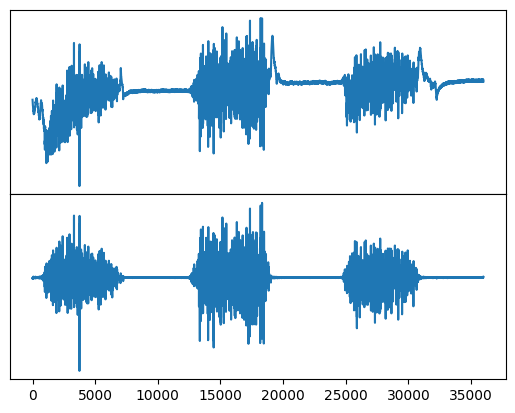

In [ ]:
subject_id = 4
class_id = 1
channel_id = 2


raw_signal = TIADS1299_dataset.raw_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id])

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id])

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].plot(raw_signal.data[0][:,channel_id]);
axs[0].set_yticks([]);
axs[1].plot(filtered_signal.data[0][:,channel_id]);
axs[1].set_yticks([]);


Check if golden data values are equal to the last part of the filtered signal for same subject and class

In [37]:
subject_id = 7
class_id = 1
channel_id = 2

gd_df = pd.read_csv(
    '/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/golden_data/splits.csv',
    header=0, names=['subject_id', 'class_id', 'start', 'end']
)

record = gd_df[(gd_df['subject_id'] == subject_id) & (gd_df['class_id'] == class_id)].to_dict('records')[0]


filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][record['start']:record['end'], channel_id]

gd_signal = TIADS1299_dataset.golden_data_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

check = np.allclose(
    filtered_signal,
    gd_signal
)

print("Same values in filtered and golden data for channel:", check)

Same values in filtered and golden data for channel: True


Check if for stage `AllKmeansNoRestStage` there are some sequence of values that match with some sequence in frequency filtered data

In [53]:
subject_id = 2
class_id = 3
channel_id = 2

def check_share_common_sequence(a: np.ndarray, b: np.ndarray, length: int = 10) -> bool:
    """
    Checks whether two numpy arrays share any common contiguous subsequence
    of the specified length. Returns True if at least one such sequence is found,
    otherwise returns False.

    Args:
        a (np.ndarray): First input array.
        b (np.ndarray): Second input array.
        length (int): Length of the subsequence to compare (default is 5).

    Returns:
        bool: True if a common subsequence of the given length exists in both arrays, False otherwise.
    """
    a_subs = {tuple(a[i:i+length]) for i in range(len(a) - length + 1)}
    b_subs = {tuple(b[i:i+length]) for i in range(len(b) - length + 1)}
    
    return not a_subs.isdisjoint(b_subs)

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]


aknrs_signal = TIADS1299_dataset.all_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllKmeansNoRestStage data for channel:", check_share_common_sequence(filtered_signal, aknrs_signal))

Same sequence in filtered and AllKmeansNoRestStage data for channel: True


Check if for stage `TrainKmeansNoRestStage` there are some sequence of values that match with some sequence in frequency filtered data  and if we have less values in `TrainKmeansNoRestStage`, that is created from a trimmed version of filtered data (we remove the last burst), than in `AllKmeansNoRestStage`

In [64]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

aknrs_signal = TIADS1299_dataset.all_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]


tknrs_signal = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and TrainKmeansNoRestStage data for channel:", check_share_common_sequence(filtered_signal, tknrs_signal))
print("TrainKmeansNoRestStage have less values than AllKmeansNoRestStage:", len(tknrs_signal) < len(aknrs_signal))

Same sequence in filtered and TrainKmeansNoRestStage data for channel: True
TrainKmeansNoRestStage have less values than AllKmeansNoRestStage: True


Check if for stage `AllPct70NoRestStage` there are some sequence of values that match with some sequence in frequency filtered data and that the number of samples is almost the 70% of 6000 samples (3 seconds * 2Khz) by 3 action burst -> 12600 samples

In [65]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

ap70nrs_signal = TIADS1299_dataset.all_pct70_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllPct70NoRestStage data for channel:",check_share_common_sequence(filtered_signal, ap70nrs_signal))
print(len(ap70nrs_signal), 0.7*3*2000*3)

Same sequence in filtered and AllPct70NoRestStage data for channel: True
12599 12599.999999999996


Check if for stage `TrainPct70NoRestStage` there are some sequence of values that match with some sequence in frequency filtered data and that the number of samples is almost the 70% of 6000 samples (3 seconds * 2Khz) by 2 action burst -> 12600 samples (In Train... stage data we have removed the last burst.

In [68]:
subject_id = 2
class_id = 3
channel_id = 2

filtered_signal = TIADS1299_dataset.freq_filtered_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

tp70nrs_signal = TIADS1299_dataset.train_pct70_no_rest_stage.odh.\
    isolate_data('subjects', [subject_id]).\
    isolate_data('classes', [class_id]).\
    data[0][:, channel_id]

print("Same sequence in filtered and AllPct70NoRestStage data for channel:",check_share_common_sequence(filtered_signal, tp70nrs_signal))
print(len(tp70nrs_signal), 0.7*3*2000*2)

Same sequence in filtered and AllPct70NoRestStage data for channel: True
8399 8399.999999999998


## Evaluations

In [22]:
from libemg.emg_predictor import EMGClassifier
from libemg.offline_metrics import OfflineMetrics
from itertools import combinations


def get_windows(odh: OfflineDataHandler):
    window_seconds_size = 0.25
    window_seconds_step = 0.05
    window_samples_size = int(window_seconds_size*2000)
    window_samples_step = int(window_seconds_step*2000)
    windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
    
    return windows, metadata


def get_feature_set(windows):
    fe = FeatureExtractor()
    features = fe.extract_feature_group("HTD", windows, array=True)
    
    return features
    

def get_trained_classifier(odh: OfflineDataHandler):
    windows, metadata = get_windows(odh)
    features = get_feature_set(windows)
    feature_set = {
        'training_features': features,
        'training_labels': metadata['classes']
    }
    clf = EMGClassifier('LDA')
    clf.fit(feature_set)
    
    return clf


def get_test_metrics(clf: EMGClassifier, test_odh: OfflineDataHandler):
    test_windows, test_metadata = get_windows(test_odh)
    test_feature_set = get_feature_set(test_windows)
    clf_predictions, _ = clf.run(test_feature_set)
    om = OfflineMetrics()
    classification_metrics = om.extract_common_metrics(test_metadata['classes'], clf_predictions, null_label=None) 
    return classification_metrics


def get_dataset_metrics(
    train_odh: OfflineDataHandler, 
    test_odh: OfflineDataHandler, 
    classes: List, 
    train_subjects: List, 
    test_subjects: List) -> Dict[str, float]:
    
    assert set(train_subjects).isdisjoint(test_subjects), "There are common subjects in train and test sets"
    
    isolated_train_odh = train_odh.isolate_data('subjects', train_subjects).isolate_data('classes', classes)
    isolated_test_odh = test_odh.isolate_data('subjects', test_subjects).isolate_data('classes', classes)
    
    clf = get_trained_classifier(isolated_train_odh)
    metrics = get_test_metrics(clf, isolated_test_odh)
    
    return metrics

In [135]:
results = []

for test_subject in range(8):
    availables_train_subjects = list(range(8))
    availables_train_subjects.remove(test_subject)
    
    for num_train_subjects in range(1, len(availables_train_subjects) + 1):
    
        for train_subjects in combinations(availables_train_subjects, num_train_subjects):

            for last_mov_class in range(2,10):
                test_subject_lst = [test_subject]
                train_subjects_lst = list(train_subjects)
                
                
                movements = list(range(10))[:last_mov_class]
                print(test_subject, train_subjects, movements)
            
                kmeans_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.train_kmeans_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                pct70_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.train_pct70_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                results.append({
                    'num_test_subjects': len(test_subject_lst),
                    'num_train_subjects': len(train_subjects_lst),
                    'num_movements': len(movements),
                    'test_subjects': '|'.join([str(i) for i in test_subject_lst]),
                    'train_subjects': '|'.join([str(i) for i in train_subjects_lst]),
                    'movements': '|'.join([str(i) for i in movements]),
                    'kmeans_acc': kmeans_metrics['CA'],
                    'pct70_acc': pct70_metrics['CA']
                })
                


0 (1,) [0, 1]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5, 6]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5, 6, 7]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1,

In [137]:
pd.DataFrame(results).to_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_trainkmeans_vs_trainpct70_golden_test.csv',
    index=False
)

In [2]:
df = pd.read_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_trainkmeans_vs_trainpct70_golden_test.csv'
)

In [23]:
results = []

for test_subject in range(8):
    availables_train_subjects = list(range(8))
    availables_train_subjects.remove(test_subject)
    
    for num_train_subjects in range(1, len(availables_train_subjects) + 1):
    
        for train_subjects in combinations(availables_train_subjects, num_train_subjects):

            for last_mov_class in range(2,10):
                test_subject_lst = [test_subject]
                train_subjects_lst = list(train_subjects)
                
                
                movements = list(range(10))[:last_mov_class]
                print(test_subject, train_subjects, movements)
            
                kmeans_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.all_kmeans_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                pct70_metrics = get_dataset_metrics(
                    train_odh=TIADS1299_dataset.all_pct70_no_rest_stage.odh, 
                    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
                    classes=movements, 
                    train_subjects=train_subjects_lst, 
                    test_subjects=test_subject_lst
                )
                
                results.append({
                    'num_test_subjects': len(test_subject_lst),
                    'num_train_subjects': len(train_subjects_lst),
                    'num_movements': len(movements),
                    'test_subjects': '|'.join([str(i) for i in test_subject_lst]),
                    'train_subjects': '|'.join([str(i) for i in train_subjects_lst]),
                    'movements': '|'.join([str(i) for i in movements]),
                    'kmeans_acc': kmeans_metrics['CA'],
                    'pct70_acc': pct70_metrics['CA']
                })
                

0 (1,) [0, 1]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5, 6]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1, 2, 3, 4, 5, 6, 7]
AER not computed... Please input the null_label parameter.
AER not computed... Please input the null_label parameter.
0 (1,) [0, 1,

In [24]:
pd.DataFrame(results).to_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_allkmeans_vs_allnpct70_golden_test.csv',
    index=False
)

In [3]:
df = pd.read_csv(
    '/workspaces/EMGStateDetect/backup_data/10mov4chFU_AFEs/ADS/results/all_users_all_movements_allkmeans_vs_allnpct70_golden_test.csv'
)

# Visualizations

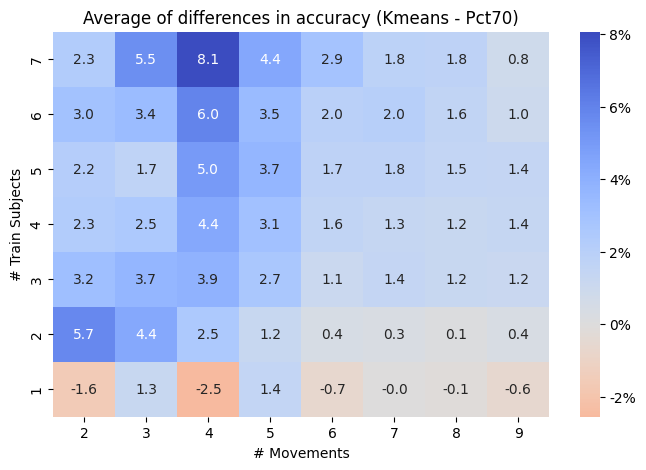

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Paso 1: Crear la columna de diferencia
df['diff'] = (df['kmeans_acc'] - df['pct70_acc'])*100

# Paso 2: Agrupar y pivotear
pivot_df = (
    df.groupby(['num_train_subjects', 'num_movements'])['diff']
    .mean()
    .reset_index()
    .pivot(index='num_train_subjects', columns='num_movements', values='diff')
)

plt.figure(figsize=(8, 5))
ax = sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".1f",
    cmap="coolwarm_r",
    center=0
)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.title('Average of differences in accuracy (Kmeans - Pct70)')
plt.xlabel('# Movements')
plt.ylabel('# Train Subjects')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
test_odh.isolate_data('subjects', test_subjects).isolate_data('classes', classes)

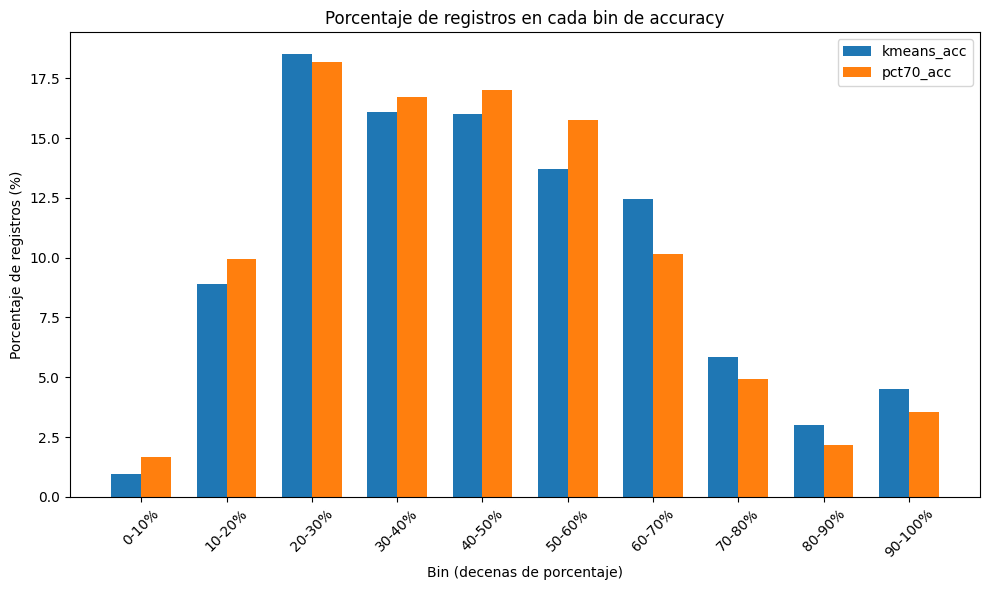

In [23]:
import pandas as pd
import numpy as np

# Suponiendo que ya tienes los bins creados
bins = np.arange(0, 1.1, 0.1)
labels = [f'{int(l*100)}-{int(r*100)}%' for l, r in zip(bins[:-1], bins[1:])]


df['kmeans_acc'] = df['kmeans_acc'].replace(1, 0.99)
df['pct70_acc'] = df['pct70_acc'].replace(1, 0.99)


df['kmeans_bin'] = pd.cut(df['kmeans_acc'], bins=bins, labels=labels, right=False, include_lowest=True)
df['pct70_bin'] = pd.cut(df['pct70_acc'], bins=bins, labels=labels, right=False, include_lowest=True)

# Cuenta los registros para cada bin
kmeans_counts = df['kmeans_bin'].value_counts().sort_index()
pct70_counts = df['pct70_bin'].value_counts().sort_index()

total_registros = len(df)

kmeans_pct = (kmeans_counts / total_registros) * 100
pct70_pct = (pct70_counts / total_registros) * 100

plot_df = pd.DataFrame({
    'kmeans_acc': kmeans_pct,
    'pct70_acc': pct70_pct
})
plot_df.index.name = 'bin'
plot_df = plot_df.reset_index()

x = np.arange(len(plot_df['bin']))  # Posiciones de los bins
width = 0.35  # Ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, plot_df['kmeans_acc'], width, label='kmeans_acc')
plt.bar(x + width/2, plot_df['pct70_acc'], width, label='pct70_acc')

plt.xlabel('Bin (decenas de porcentaje)')
plt.ylabel('Porcentaje de registros (%)')
plt.title('Porcentaje de registros en cada bin de accuracy')
plt.xticks(x, plot_df['bin'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Mi teoria es que kmeans lo hace peor que pct70 en aquellos caso en los que pct70 ya de por si lo hace mal

In [17]:
f_df = df[(df['test_subjects']!= '6') & (~df['train_subjects'].astype(str).str.contains('6'))]
print(f_df['kmeans_acc'].mean())
print(f_df['pct70_acc'].mean())

0.43607706450870276
0.42017881953782693


In [18]:
filtered = df[df['kmeans_acc'] < df['pct70_acc']]
filtered['diff'] = (filtered['pct70_acc']- filtered['kmeans_acc']) * 100
filtered['tens'] = filtered['pct70_acc']*100 // 10 
filtered.sort_values(by='diff', ascending=False)

/tmp/ipykernel_831/4260270815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['diff'] = (filtered['pct70_acc']- filtered['kmeans_acc']) * 100
/tmp/ipykernel_831/4260270815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['tens'] = filtered['pct70_acc']*100 // 10


num_test_subjects  num_train_subjects  num_movements  test_subjects  \
4105                  1                   1              3              4   
3056                  1                   1              2              3   
3089                  1                   1              3              3   
5104                  1                   1              2              5   
3200                  1                   2              2              3   
...                 ...                 ...            ...            ...   
1743                  1                   4              9              1   
4519                  1                   3              9              4   
4687                  1                   4              9              4   
2911                  1                   5              9              2   
2223                  1                   2              9              2   

     train_subjects          movements  kmeans_acc  pct70_acc       diff  \
4105              6              0|1|2    0.304688   1.000000  69.531250   
3056              1                0|1    0.153846   0.747253  59.340659   
3089              6              0|1|2    0.300000   0.815385  51.538462   
5104              3                0|1    0.487179   1.000000  51.282051   
3200            2|5                0|1    0.417582   0.923077  50.549451   
...             ...                ...         ...        ...        ...   
1743        2|4|5|7  0|1|2|3|4|5|6|7|8    0.157635   0.160099   0.246305   
4519          2|5|6  0|1|2|3|4|5|6|7|8    0.561743   0.564165   0.242131   
4687        0|2|5|7  0|1|2|3|4|5|6|7|8    0.380145   0.382567   0.242131   
2911      0|3|4|5|7  0|1|2|3|4|5|6|7|8    0.122642   0.125000   0.235849   
2223            4|6  0|1|2|3|4|5|6|7|8    0.113208   0.115566   0.235849   

     kmeans_bin pct70_bin  tens  
4105     30-40%       NaN  10.0  
3056     10-20%    70-80%   7.0  
3089     20-30%    80-90%   8.0  
5104     40-50%       NaN  10.0  
3200     40-50%   90-100%   9.0  
...         ...       ...   ...  
1743     10-20%    10-20%   1.0  
4519     50-60%    50-60%   5.0  
4687     30-40%    30-40%   3.0  
2911     10-20%    10-20%   1.0  
2223     10-20%    10-20%   1.0  

[3093 rows x 12 columns]

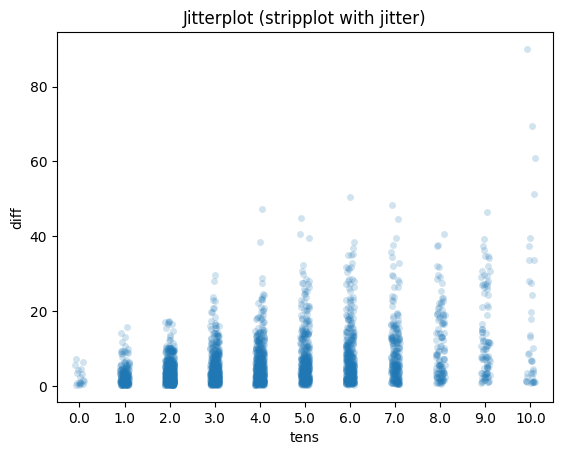

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(
    x='tens', 
    y='diff', 
    data=filtered, 
    jitter=True,       # adds the jitter!
    alpha=0.2
)
plt.title('Jitterplot (stripplot with jitter)')
plt.show()

In [199]:
import numpy as np
df = filtered = df[df['kmeans_acc'] < df['pct70_acc']]

# Si tienes los accuracies como proporciones (0 a 1), conviértelos a % si prefieres
df['mean_acc'] = (df['kmeans_acc'] + df['pct70_acc']) / 2

bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, ..., 1.0
labels = [f'{int(left*100)}-{int(right*100)}%' for left, right in zip(bins[:-1], bins[1:])]

df['acc_bin'] = pd.cut(df['pct70_acc'], bins=bins, labels=labels, include_lowest=True, right=False)

df['diff'] =  df['pct70_acc'] - df['kmeans_acc']
mean_diffs = df.groupby('acc_bin')['diff'].mean()

/tmp/ipykernel_599/600145157.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_diffs = df.groupby('acc_bin')['diff'].mean()


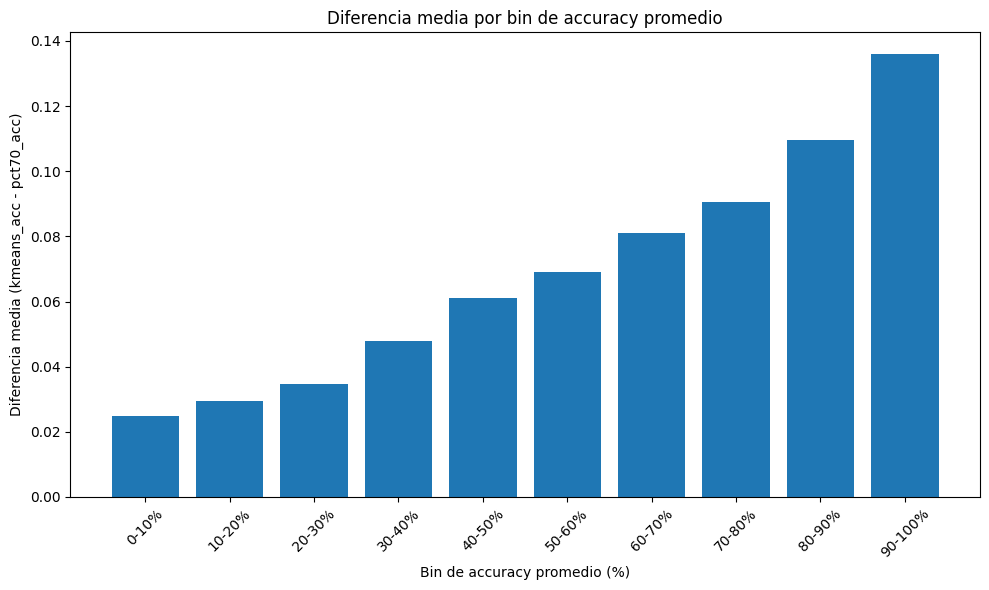

In [200]:
import matplotlib.pyplot as plt

mean_diffs = mean_diffs.reindex(labels)  # Asegura el orden correcto de los bins

plt.figure(figsize=(10, 6))
plt.bar(mean_diffs.index, mean_diffs.values)
plt.xlabel('Bin de accuracy promedio (%)')
plt.ylabel('Diferencia media (kmeans_acc - pct70_acc)')
plt.title('Diferencia media por bin de accuracy promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

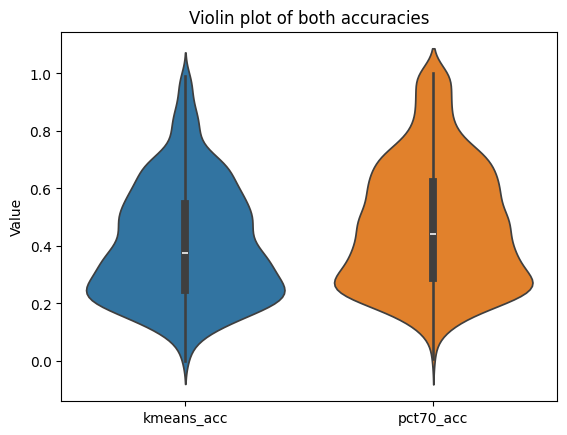

In [193]:
pd.set_option('display.max_rows', 100)
filtered = df[df['kmeans_acc'] < df['pct70_acc']]
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=filtered[['kmeans_acc', 'pct70_acc']])
plt.title('Violin plot of both accuracies')
plt.ylabel('Value')
plt.show()

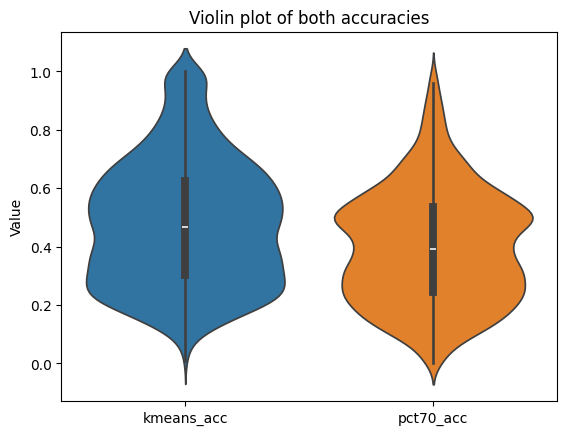

In [194]:
pd.set_option('display.max_rows', 100)
filtered = df[df['kmeans_acc'] > df['pct70_acc']]
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=filtered[['kmeans_acc', 'pct70_acc']])
plt.title('Violin plot of both accuracies')
plt.ylabel('Value')
plt.show()

In [174]:
import numpy as np

# Asegúrate que tus columnas son proporciones (0 a 1), si están en %, divídelas entre 100
bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, ..., 1.0

df['kmeans_bin'] = pd.cut(df['kmeans_acc'], bins=bins, right=False, include_lowest=True)
df['pct70_bin'] = pd.cut(df['pct70_acc'], bins=bins, right=False, include_lowest=True)

In [175]:
filtered = df[df['kmeans_acc'] > df['pct70_acc']]

count_df = (
    filtered.groupby(['kmeans_bin', 'pct70_bin'])
    .size()
    .unstack(fill_value=0)
)

/tmp/ipykernel_599/3230764988.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['kmeans_bin', 'pct70_bin'])


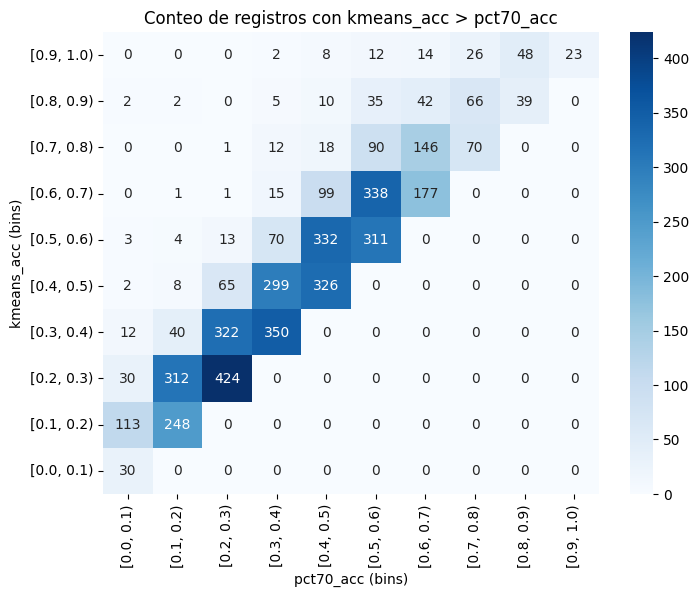

In [176]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    count_df,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title('Conteo de registros con kmeans_acc > pct70_acc')
plt.xlabel('pct70_acc (bins)')
plt.ylabel('kmeans_acc (bins)')
plt.gca().invert_yaxis()  # Opcional: para que 0-0.1 quede abajo
plt.show()

/tmp/ipykernel_599/45530408.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['kmeans_bin', 'pct70_bin'])


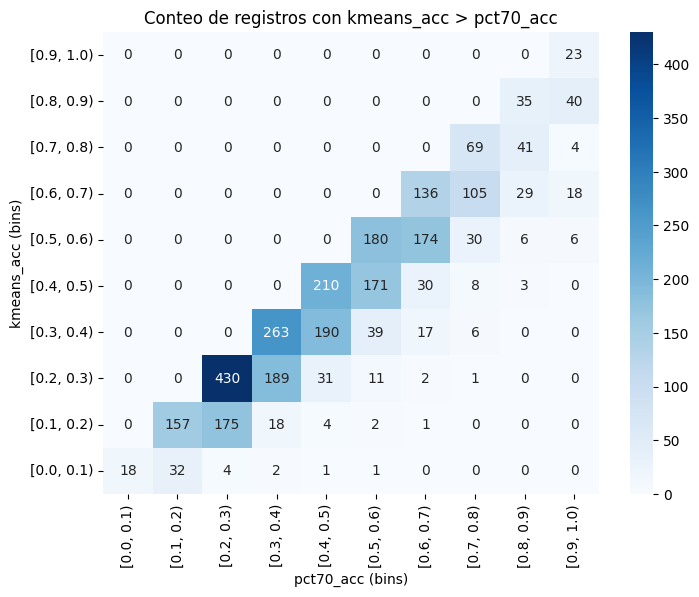

In [177]:
filtered = df[df['kmeans_acc'] < df['pct70_acc']]

count_df = (
    filtered.groupby(['kmeans_bin', 'pct70_bin'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    count_df,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title('Conteo de registros con kmeans_acc > pct70_acc')
plt.xlabel('pct70_acc (bins)')
plt.ylabel('kmeans_acc (bins)')
plt.gca().invert_yaxis()  # Opcional: para que 0-0.1 quede abajo
plt.show()

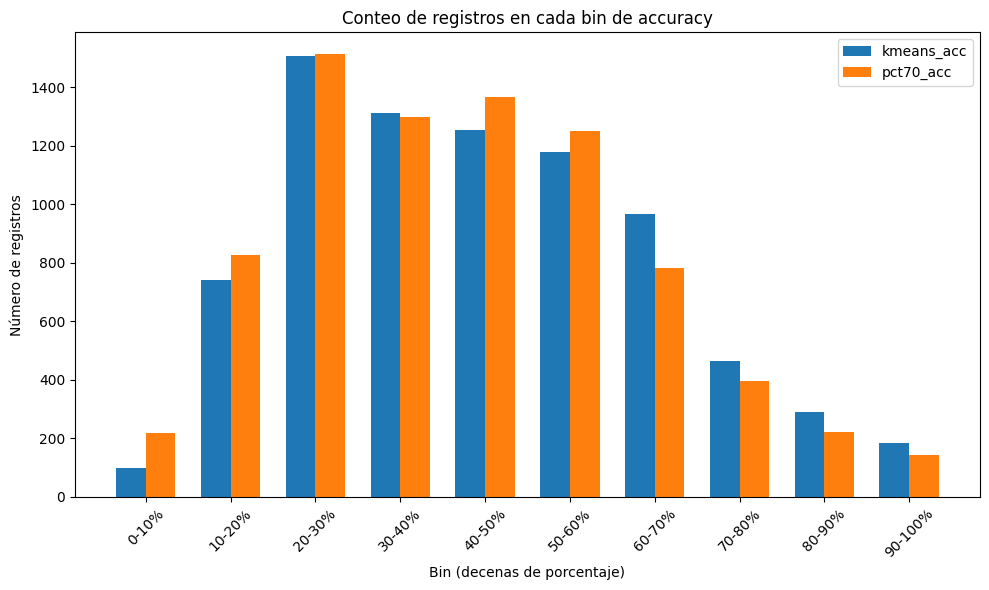

In [179]:
import pandas as pd
import numpy as np

# Suponiendo que ya tienes los bins creados
bins = np.arange(0, 1.1, 0.1)
labels = [f'{int(l*100)}-{int(r*100)}%' for l, r in zip(bins[:-1], bins[1:])]

df['kmeans_bin'] = pd.cut(df['kmeans_acc'], bins=bins, labels=labels, right=False, include_lowest=True)
df['pct70_bin'] = pd.cut(df['pct70_acc'], bins=bins, labels=labels, right=False, include_lowest=True)

# Cuenta los registros para cada bin
kmeans_counts = df['kmeans_bin'].value_counts().sort_index()
pct70_counts = df['pct70_bin'].value_counts().sort_index()

plot_df = pd.DataFrame({
    'kmeans_acc': kmeans_counts,
    'pct70_acc': pct70_counts
})
plot_df.index.name = 'bin'
plot_df = plot_df.reset_index()

import matplotlib.pyplot as plt

x = np.arange(len(plot_df['bin']))  # Posiciones de los bins
width = 0.35  # Ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, plot_df['kmeans_acc'], width, label='kmeans_acc')
plt.bar(x + width/2, plot_df['pct70_acc'], width, label='pct70_acc')

plt.xlabel('Bin (decenas de porcentaje)')
plt.ylabel('Número de registros')
plt.title('Conteo de registros en cada bin de accuracy')
plt.xticks(x, plot_df['bin'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [181]:
total_registros = len(df)

kmeans_pct = (kmeans_counts / total_registros) * 100
pct70_pct = (pct70_counts / total_registros) * 100

plot_df = pd.DataFrame({
    'kmeans_acc': kmeans_pct,
    'pct70_acc': pct70_pct
})
plot_df.index.name = 'bin'
plot_df = plot_df.reset_index()

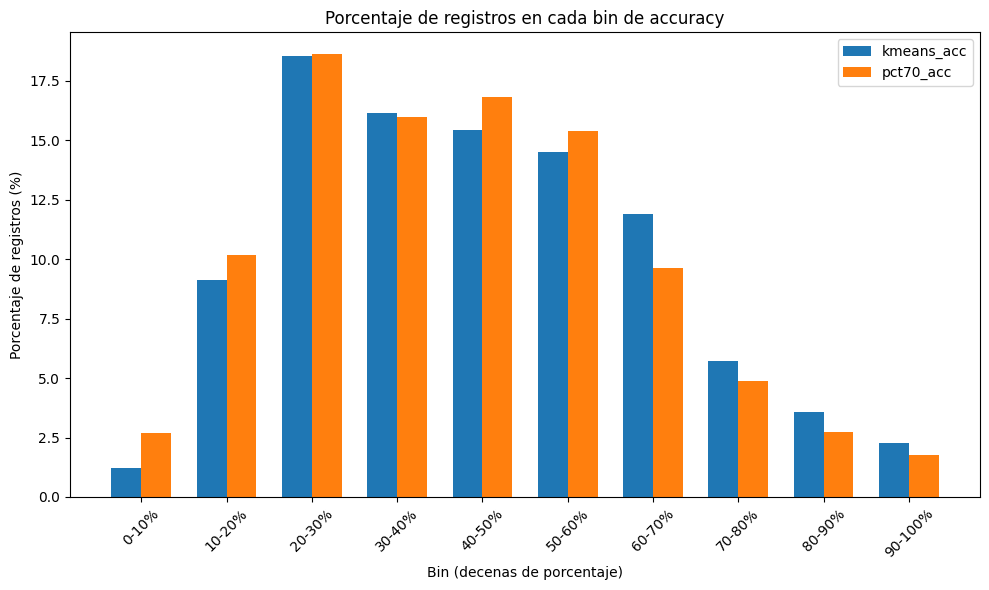

In [182]:
x = np.arange(len(plot_df['bin']))  # Posiciones de los bins
width = 0.35  # Ancho de cada barra

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, plot_df['kmeans_acc'], width, label='kmeans_acc')
plt.bar(x + width/2, plot_df['pct70_acc'], width, label='pct70_acc')

plt.xlabel('Bin (decenas de porcentaje)')
plt.ylabel('Porcentaje de registros (%)')
plt.title('Porcentaje de registros en cada bin de accuracy')
plt.xticks(x, plot_df['bin'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

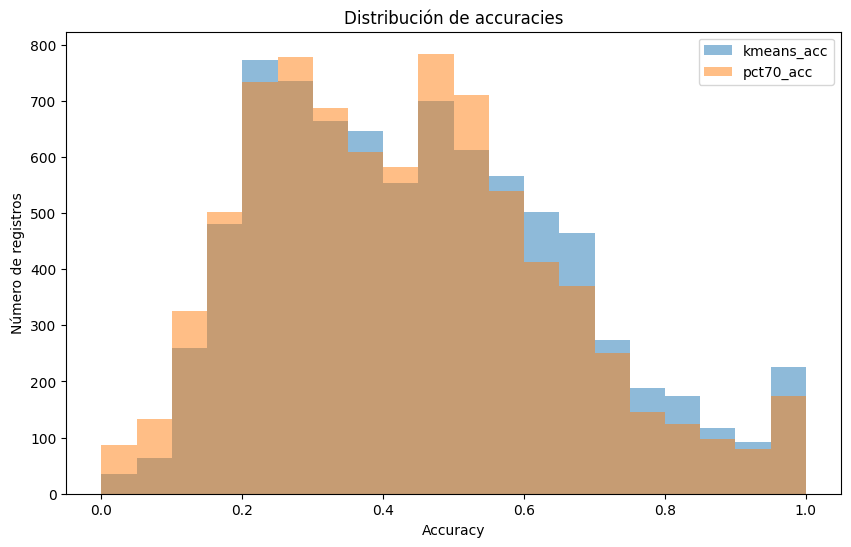

In [183]:
plt.figure(figsize=(10, 6))
plt.hist(df['kmeans_acc'], bins=20, alpha=0.5, label='kmeans_acc')
plt.hist(df['pct70_acc'], bins=20, alpha=0.5, label='pct70_acc')
plt.xlabel('Accuracy')
plt.ylabel('Número de registros')
plt.title('Distribución de accuracies')
plt.legend()
plt.show()

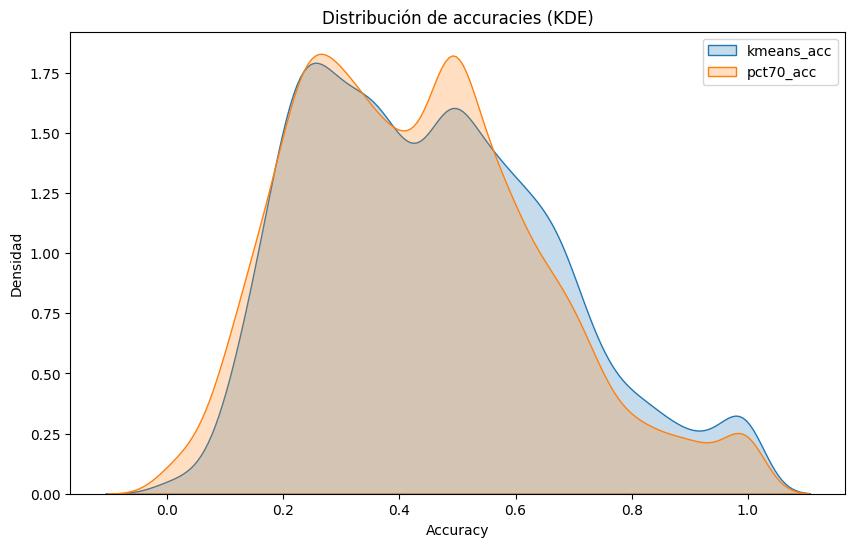

In [184]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['kmeans_acc'], fill=True, label='kmeans_acc')
sns.kdeplot(df['pct70_acc'], fill=True, label='pct70_acc')
plt.xlabel('Accuracy')
plt.ylabel('Densidad')
plt.title('Distribución de accuracies (KDE)')
plt.legend()
plt.show()

In [164]:
df[df['pct70_acc']==df['pct70_acc'].max()]

num_test_subjects  num_train_subjects  num_movements  test_subjects  \
8                     1                   1              2              0   
56                    1                   2              2              0   
2032                  1                   1              2              2   
3056                  1                   1              2              3   
3080                  1                   1              2              3   
...                 ...                 ...            ...            ...   
6256                  1                   2              2              6   
6320                  1                   3              2              6   
6344                  1                   3              2              6   
6456                  1                   3              2              6   
6616                  1                   4              2              6   

     train_subjects movements  kmeans_acc  pct70_acc  
8                 2       0|1    1.000000        1.0  
56              1|2       0|1    0.988235        1.0  
2032              0       0|1    0.389474        1.0  
3056              1       0|1    0.098901        1.0  
3080              5       0|1    1.000000        1.0  
...             ...       ...         ...        ...  
6256            2|5       0|1    0.605263        1.0  
6320          0|1|2       0|1    1.000000        1.0  
6344          0|1|5       0|1    1.000000        1.0  
6456          1|2|5       0|1    1.000000        1.0  
6616        0|1|2|5       0|1    0.960526        1.0  

[108 rows x 8 columns]

In [165]:
(df['pct70_acc'] - df['kmeans_acc']).max()

0.9010989010989011

In [166]:
(df['kmeans_acc'] - df['pct70_acc']).max()

0.8315789473684211

In [159]:
df['test'] = df['train_subjects'].apply(lambda x: ','.join([str(j) for j in sorted([int(i) for i in x.split('|')])]))

In [152]:
df.groupby(['train_subjects']).aggregate({
    'kmeans_acc': ['mean', 'std'],
    'pct70_acc': ['mean', 'std']
})

kmeans_acc           pct70_acc          
                     mean       std      mean       std
train_subjects                                         
0                0.303970  0.161666  0.352299  0.200573
0|1              0.440528  0.223250  0.430925  0.185260
0|1|2            0.381461  0.208096  0.373958  0.230218
0|1|2|3          0.430715  0.212093  0.366288  0.175862
0|1|2|3|4        0.446802  0.157440  0.429850  0.161077
...                   ...       ...       ...       ...
5|6|7            0.461382  0.243443  0.390496  0.231979
5|7              0.411621  0.209459  0.404600  0.205984
6                0.384294  0.209818  0.398516  0.220308
6|7              0.468948  0.227417  0.455689  0.208671
7                0.409150  0.241723  0.415031  0.232322

[254 rows x 4 columns]

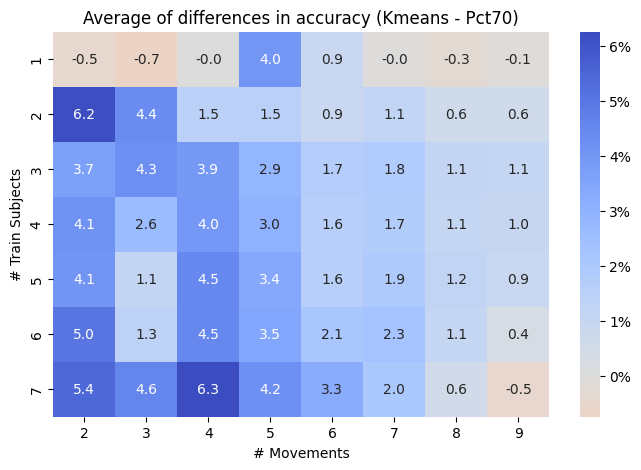

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Paso 1: Crear la columna de diferencia
df['diff'] = (df['kmeans_acc'] - df['pct70_acc'])*100

# Paso 2: Agrupar y pivotear
pivot_df = (
    df.groupby(['num_train_subjects', 'num_movements'])['diff']
    .mean()
    .reset_index()
    .pivot(index='num_train_subjects', columns='num_movements', values='diff')
)

plt.figure(figsize=(8, 5))
ax = sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".1f",
    cmap="coolwarm_r",  # rojo-negativo, blanco-cero, azul-positivo
    center=0          # centra el color en 0
)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.title('Average of differences in accuracy (Kmeans - Pct70)')
plt.xlabel('# Movements')
plt.ylabel('# Train Subjects')
plt.show()

In [112]:
get_dataset_metrics(
    train_odh=TIADS1299_dataset.train_pct70_no_rest_stage.odh, 
    test_odh=TIADS1299_dataset.golden_data_stage.odh, 
    classes=[0,1,2,3,4], 
    train_subjects=[5,1,2,3,0], 
    test_subjects=[4,7]
)

AER not computed... Please input the null_label parameter.


{'CA': 0.36574074074074076, 'INS': 0.09490740740740741}

In [93]:
odh = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.isolate_data("subjects", [5,1,2,3])
train_odh = odh.isolate_data("classes", [0,1,2,3])

clf = get_trained_classifier(train_odh)

odh = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.isolate_data("subjects", [4])
test_odh = odh.isolate_data("classes", [0,1,2,3])

get_test_metrics(clf, test_odh)

AER not computed... Please input the null_label parameter.


{'CA': 0.6879120879120879, 'INS': 0.026373626373626374}

AER not computed... Please input the null_label parameter.
{'CA': 0.7488479262672811, 'INS': 0.08986175115207373}


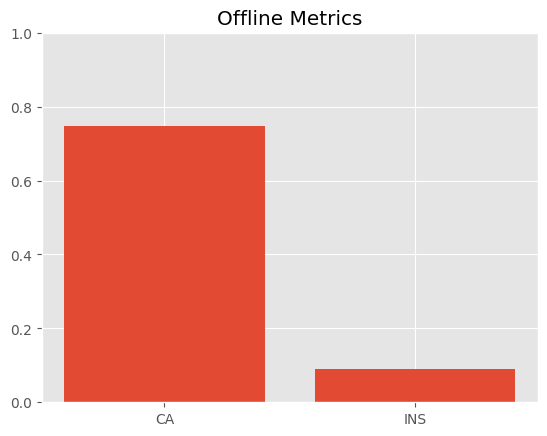

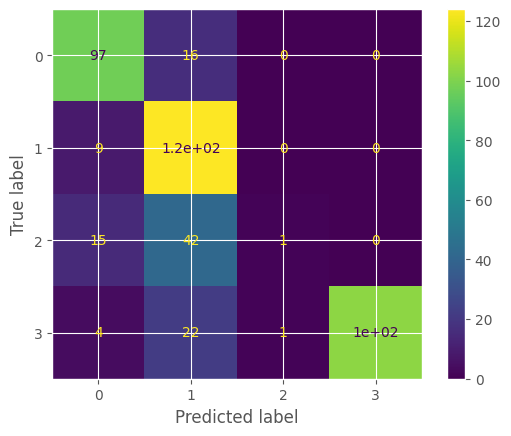

In [20]:
window_seconds_size = 0.25
window_seconds_step = 0.05
window_samples_size = int(window_seconds_size*2000)
window_samples_step = int(window_seconds_step*2000)


odh = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.isolate_data("subjects", [0,1,2,3,4,6])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

train_features = fe.extract_feature_group("HTD", windows, array=True)
train_labels = metadata['classes']


from libemg.emg_predictor import EMGClassifier

clf = EMGClassifier('LDA')

feature_set = {
    'training_features': train_features,
    'training_labels': train_labels
}
clf.fit(feature_set)


odh = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.isolate_data("subjects", [5])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

test_features = fe.extract_feature_group("HTD", windows, array=True)
test_labels = metadata['classes']


from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()

clf_predictions, _ = clf.run(test_features)
null_label = None  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_labels, clf_predictions)
om.visualize_conf_matrix(mat)

AER not computed... Please input the null_label parameter.
{'CA': 0.5854430379746836, 'INS': 0.11075949367088607}


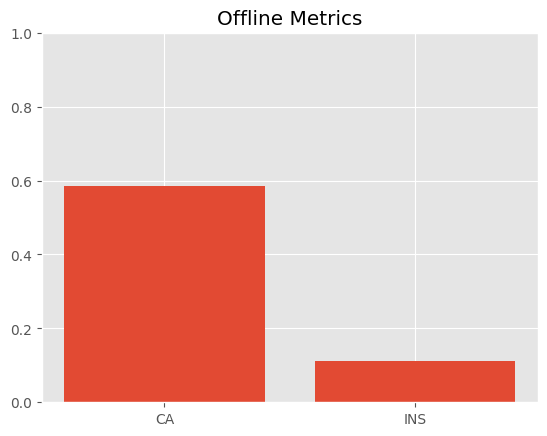

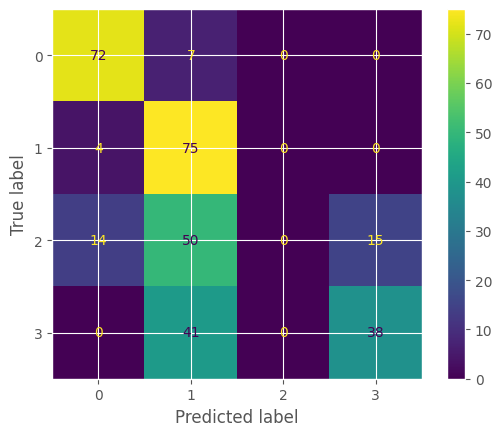

In [21]:
window_seconds_size = 0.25
window_seconds_step = 0.05
window_samples_size = int(window_seconds_size*2000)
window_samples_step = int(window_seconds_step*2000)


odh = TIADS1299_dataset.train_pct70_no_rest_stage.odh.isolate_data("subjects", [0,1,2,3,4,6])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

train_features = fe.extract_feature_group("HTD", windows, array=True)
train_labels = metadata['classes']


from libemg.emg_predictor import EMGClassifier

clf = EMGClassifier('LDA')

feature_set = {
    'training_features': train_features,
    'training_labels': train_labels
}
clf.fit(feature_set)


odh = TIADS1299_dataset.train_pct70_no_rest_stage.odh.isolate_data("subjects", [5])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

test_features = fe.extract_feature_group("HTD", windows, array=True)
test_labels = metadata['classes']


from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()

clf_predictions, _ = clf.run(test_features)
null_label = None  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_labels, clf_predictions)
om.visualize_conf_matrix(mat)

AER not computed... Please input the null_label parameter.
{'CA': 0.7207792207792207, 'INS': 0.05194805194805195}


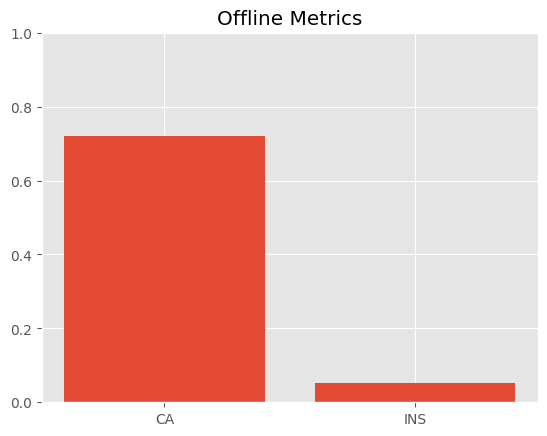

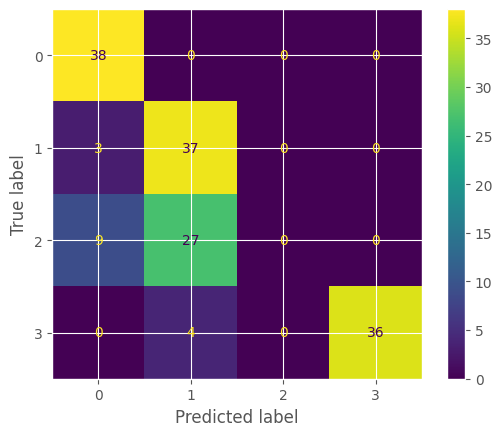

In [41]:
window_seconds_size = 0.25
window_seconds_step = 0.05
window_samples_size = int(window_seconds_size*2000)
window_samples_step = int(window_seconds_step*2000)


odh = TIADS1299_dataset.train_kmeans_no_rest_stage.odh.isolate_data("subjects", [0,1,2,3,4,6])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

train_features = fe.extract_feature_group("HTD", windows, array=True)
train_labels = metadata['classes']


from libemg.emg_predictor import EMGClassifier

clf = EMGClassifier('LDA')

feature_set = {
    'training_features': train_features,
    'training_labels': train_labels
}
clf.fit(feature_set)


odh = TIADS1299_dataset.golden_data_stage.odh.isolate_data("subjects", [5])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

test_features = fe.extract_feature_group("HTD", windows, array=True)
test_labels = metadata['classes']


from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()

clf_predictions, _ = clf.run(test_features)
null_label = None  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_labels, clf_predictions)
om.visualize_conf_matrix(mat)

AER not computed... Please input the null_label parameter.
{'CA': 0.6168831168831169, 'INS': 0.07792207792207792}


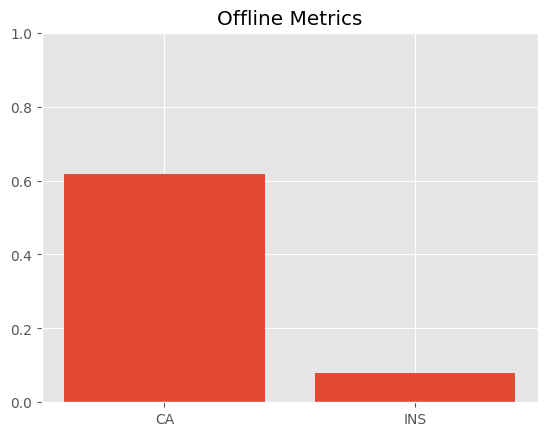

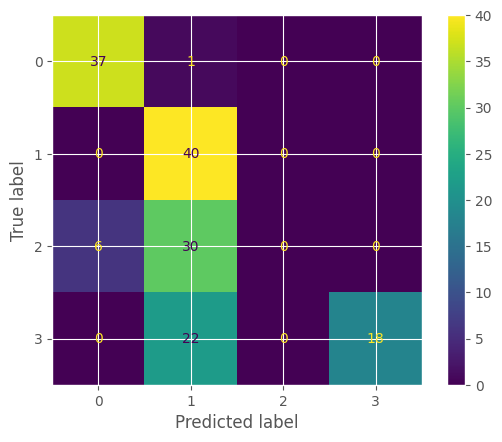

In [40]:
window_seconds_size = 0.25
window_seconds_step = 0.05
window_samples_size = int(window_seconds_size*2000)
window_samples_step = int(window_seconds_step*2000)


odh = TIADS1299_dataset.train_pct70_no_rest_stage.odh.isolate_data("subjects", [0,1,2,3,4,6])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

train_features = fe.extract_feature_group("HTD", windows, array=True)
train_labels = metadata['classes']


from libemg.emg_predictor import EMGClassifier

clf = EMGClassifier('LDA')

feature_set = {
    'training_features': train_features,
    'training_labels': train_labels
}
clf.fit(feature_set)


odh = TIADS1299_dataset.golden_data_stage.odh.isolate_data("subjects", [5])
odh = odh.isolate_data("classes", [0,1,2,3])


windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

test_features = fe.extract_feature_group("HTD", windows, array=True)
test_labels = metadata['classes']


from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()

clf_predictions, _ = clf.run(test_features)
null_label = None  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_labels, clf_predictions)
om.visualize_conf_matrix(mat)

Training on subjects: (0,)


/usr/local/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


AER not computed... Please input the null_label parameter.
{'CA': 0.9836601307189542, 'INS': 0.017429193899782137}


/usr/local/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


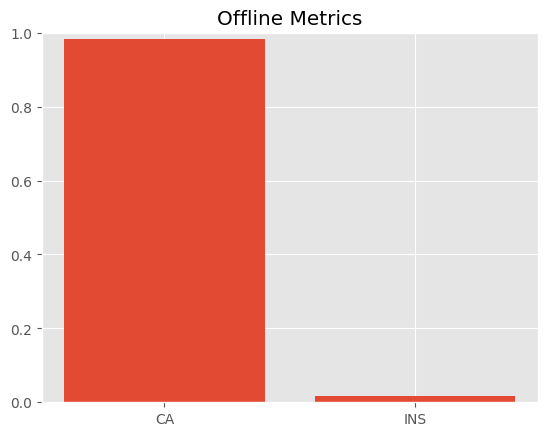

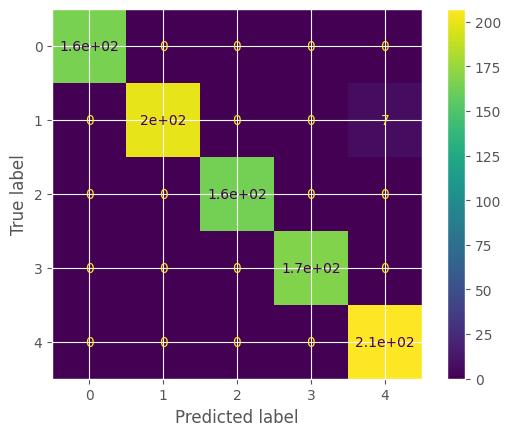

Training on subjects: (1,)


/usr/local/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


KeyboardInterrupt: 

In [15]:
from itertools import combinations

for subjects_to_train in range(7):
    for train_subjects_idx in list(combinations(range(7), subjects_to_train)):
        if len(train_subjects_idx) > 0:
            print(f"Training on subjects: {train_subjects_idx}")

            METHOD = 'MSWT'

            odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", list(train_subjects_idx))
            odh = odh.isolate_data("classes", [0,1,2,3,4,6])


            windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
            fe = FeatureExtractor()

            train_features = fe.extract_feature_group(METHOD, windows, array=True)
            train_labels = metadata['classes']


            from libemg.emg_predictor import EMGClassifier

            clf = EMGClassifier('LDA')

            feature_set = {
                'training_features': train_features,
                'training_labels': train_labels
            }
            clf.fit(feature_set)


            odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", [0])
            odh = odh.isolate_data("classes", [0,1,2,3,4])


            windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
            fe = FeatureExtractor()

            test_features = fe.extract_feature_group(METHOD, windows, array=True)
            test_labels = metadata['classes']


            from libemg.offline_metrics import OfflineMetrics

            om = OfflineMetrics()

            clf_predictions, _ = clf.run(test_features)
            null_label = None  # value corresponding to no motion - defined based on the dataset
            classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
            print(classification_metrics)
            om.visualize(classification_metrics)

            # Visualize confusion matrix
            mat = om.get_CONF_MAT(test_labels, clf_predictions)
            om.visualize_conf_matrix(mat)


In [ ]:
!pip install torch

In [98]:
import os
import pickle
fe = FeatureExtractor()

unique_subjects = list(np.unique(np.array(TIADS1299_dataset.odh.subjects)))
unique_classes = list(np.unique(np.array(TIADS1299_dataset.odh.classes)))

combinations = list(itertools.product(unique_subjects, unique_classes))

dataset = []
for subject, class_ in combinations:
    odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", [subject])
    odh = odh.isolate_data("classes", [class_])
    print(odh.data[0].shape)
    
    windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
    features = fe.extract_feature_group('HJORTH', windows, array=True)
    
    dataset.append(
        {
            'features': features,
            'class': class_,
            'subject': subject,
        }
    )



(16900, 4)
(21500, 4)
(16800, 4)
(17200, 4)
(21400, 4)
(17500, 4)
(17500, 4)
(19500, 4)
(18800, 4)
(19300, 4)
(21200, 4)
(21000, 4)
(14900, 4)
(16700, 4)
(20200, 4)
(17000, 4)
(27200, 4)
(14600, 4)
(21700, 4)
(19700, 4)
(22100, 4)
(23400, 4)
(19900, 4)
(20900, 4)
(16700, 4)
(15800, 4)
(20700, 4)
(20800, 4)
(23200, 4)
(20700, 4)
(20700, 4)
(7600, 4)
(16000, 4)
(25000, 4)
(20200, 4)
(15600, 4)
(8500, 4)
(18900, 4)
(19200, 4)
(19400, 4)
(16500, 4)
(22300, 4)
(15600, 4)
(16500, 4)
(17100, 4)
(15700, 4)
(20500, 4)
(18100, 4)
(18100, 4)
(17700, 4)
(18600, 4)
(20500, 4)
(10400, 4)
(20900, 4)
(16200, 4)
(15600, 4)
(18800, 4)
(17300, 4)
(15400, 4)
(18100, 4)
(22100, 4)
(27400, 4)
(16300, 4)
(15100, 4)
(14800, 4)
(17400, 4)
(21200, 4)
(20100, 4)
(21000, 4)
(19800, 4)
(20400, 4)
(21900, 4)
(16400, 4)
(21700, 4)
(20800, 4)
(3100, 4)
(21200, 4)
(20400, 4)
(21100, 4)
(22400, 4)


In [102]:
x_train = torch.tensor(np.vstack([d['features'] for d in dataset if d['subject'] in list(range(8))]), dtype=torch.float32)
y_train = torch.tensor([i for d in dataset for i in [d['class']]*d['features'].shape[0] if d['subject'] in list(range(8))])

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Suppose you've defined the SmallNN model:
class SmallNN(nn.Module):
    def __init__(self, num_classes: int):
        super(SmallNN, self).__init__()
        self.fc1 = nn.Linear(12, 2000)
        self.fc2 = nn.Linear(2000, 2000)
        self.fc2_ = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_(x))
        x = self.fc3(x)
        return x

# Example training and evaluation:
def train_and_evaluate(x_train, y_train):
    # Create random data: 100 samples, 16 features each, 3 classes
    x_train = x_train
    y_train = y_train

    # Wrap in a DataLoader
    dataset = TensorDataset(x_train, y_train)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Instantiate model, loss function, and optimizer
    model = SmallNN(num_classes=10)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(100):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    print(f"Accuracy: {correct / total:.2f}")

# Example usage:
train_and_evaluate(x_train, y_train)

Epoch 1, Loss: 2.0938
Epoch 2, Loss: 1.9784
Epoch 3, Loss: 2.2477
Epoch 4, Loss: 2.6601
Epoch 5, Loss: 1.9729
Epoch 6, Loss: 2.0617
Epoch 7, Loss: 1.9086
Epoch 8, Loss: 2.1799
Epoch 9, Loss: 2.2043
Epoch 10, Loss: 2.0924
Epoch 11, Loss: 2.0677
Epoch 12, Loss: 1.9782
Epoch 13, Loss: 1.9279
Epoch 14, Loss: 1.7902
Epoch 15, Loss: 1.8323
Epoch 16, Loss: 1.9678
Epoch 17, Loss: 1.7368
Epoch 18, Loss: 1.8944
Epoch 19, Loss: 1.5746
Epoch 20, Loss: 1.5303
Epoch 21, Loss: 1.5525
Epoch 22, Loss: 1.3718
Epoch 23, Loss: 1.6773
Epoch 24, Loss: 1.4621
Epoch 25, Loss: 1.6424
Epoch 26, Loss: 1.4143
Epoch 27, Loss: 1.3452
Epoch 28, Loss: 1.2235
Epoch 29, Loss: 1.6176
Epoch 30, Loss: 1.2847
Epoch 31, Loss: 1.3644
Epoch 32, Loss: 1.2056
Epoch 33, Loss: 1.0645
Epoch 34, Loss: 1.3555
Epoch 35, Loss: 1.1404
Epoch 36, Loss: 1.1948
Epoch 37, Loss: 1.0776
Epoch 38, Loss: 0.9852
Epoch 39, Loss: 1.0706
Epoch 40, Loss: 0.9651
Epoch 41, Loss: 0.8702
Epoch 42, Loss: 1.1325
Epoch 43, Loss: 0.9610
Epoch 44, Loss: 1.12